avg_best_generation = 10


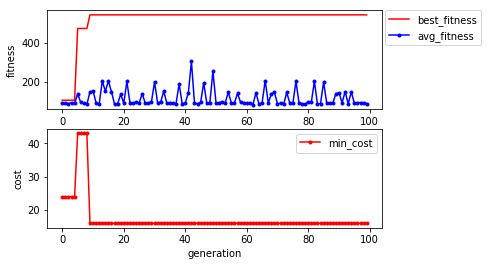

avg_best_generation = 10
在第多少次迭代时找到最优解: avg_best_generation = 10
相关信息为:  node_num=20, edge_num=37, ant_num=8, rho=0.20,c1=0, r=0.10,Q1=150.00, Q2=150.00, global_min_cost=16, respective_delay=58, best_solution=[0, 2, 5, 10, 15, 19], best_generation=10, avg_best_generation=10
最优解为: best_solution= [0, 2, 5, 10, 15, 19]
iter_time= 10
iter_time= 10.0


In [4]:
# coding=utf-8
from math import pow
from random import random
from math import log10
import matplotlib.pyplot as pl
import sys
from random import shuffle

# 输出重定向至指定的文件中，便于查看
file_obj = open('out_yuanban.txt', 'w+')
save_stdout = sys.stdout
sys.stdout = file_obj
class Graph:
    def __init__(self, node_num, edge_num):
        # 结点数
        self.node_num = node_num
        # 边数
        self.edge_num = edge_num
        # 连接状态
        self.connection_status = [[False for col in range(self.node_num)] for row in range(self.node_num)]
        # 带宽
        self.bandwidth = [[0 for col in range(self.node_num)] for row in range(self.node_num)]
        # 时延
        self.delay = [[0 for col in range(self.node_num)] for row in range(self.node_num)]
        # 花费
        self.cost = [[0 for col in range(self.node_num)] for row in range(self.node_num)]
        # 邻接点集合
        self.node_adjs = {r:[] for r in range(self.node_num)}
        # 总花费
        self.total_cost = 0
        # 总时延
        self.total_delay = 0

    def get_total_cost(self):
        return self.total_cost

    def get_total_delay(self):
        return self.total_delay

    def get_node_adjs(self):
        return self.node_adjs

    def get_delay(self):
        return self.delay

    def get_cost(self):
        return self.cost

    def add_connection_status(self, rownum, colnum):
        self.connection_status[rownum][colnum] = True
        self.connection_status[colnum][rownum] = True

    def get_connection_status(self, rownum, colnum):
        return self.connection_status[rownum][colnum]

    def add_bandwidth(self, rownum, colnum, value=0):
        self.bandwidth[rownum][colnum] = value
        self.bandwidth[colnum][rownum] = value

    def add_cost(self, rownum, colnum, value=0):
        self.cost[rownum][colnum] = value
        self.cost[colnum][rownum] = value
        self.total_cost += value

    def add_delay(self, rownum, colnum, value=0):
        self.delay[rownum][colnum] = value
        self.delay[colnum][rownum] = value
        self.total_delay += value

    def add_edge_measure(self, rownum, colnum, bandwidth, delay, cost):
        self.add_bandwidth(rownum, colnum, bandwidth)
        self.add_delay(rownum, colnum, delay)
        self.add_cost(rownum, colnum, cost)
        self.add_connection_status(rownum, colnum)

    # 初始化各边的度量参数值
    def init_edge_measure(self, fp, length):
        # 随着后期参数的增加，length的值也会增加
        print '------enter into init_edge_measure----'
        while 1:
            line = fp.readline()
            print line
            if not line:
                break
            line = line.split(',')
            param = []
            if len(line) == length:
                for k in range(length):
                    param.append(int(line[k]))

            self.add_edge_measure(*param)

    # 记录每个结点的相邻结点  like as follows:     rec = {1:[2,3],  2:[3,4]} and so on
    def init_node_adjs(self):
        for row_num in range(self.node_num):
            for col_num in range(self.node_num):
                if self.connection_status[row_num][col_num]:
                    self.node_adjs[row_num].append(col_num)
        print self.node_adjs


class GlobalInfo:
    c1 = 0.9
    c2 = 1-c1
    #第一代以后将count重新赋值为1，保证第一次迭代不会出现最优解
    count = 0
    # 当beta较大时,收敛速度较快
    TIMES = 1
    MAX_GENERATION = 100
    # Q1 / delat_delay
    Q1 = 150.0
    # Q2 / delat_cost 控制着算法的收敛速度，Q2越大收敛越快
    Q2 = 150.0
    # 信息启发因子
    alpha = 1
    # 期望启发因子5
    # beta = 1
    beta = 1
    # 信息素挥因子
    # rho  = 0.1
    rho  = 0.2
    rho2 = rho
    # 如果随机数小于或等于r则选择max{pher(r,s)}
    # 否则按照概率公式进行转移
    r = 0.1
    # 当delay>delay_w时，将其乘以一个系数
    k = 3
    # pheromone[][] 全局信息素初始值
    # C = 1  ant_num / cost create by greedy_algorithm : 4/13=0.31
    C = 0.31
    node_num = 0
    edge_num = 0
    src_node = 0
    dst_node = 0
    ant_num = 0
    delay_w = 0
    pheromone = None
    delta_pheromone = None
    # 惩罚系数
    punishment_coef = 0.7

    @staticmethod
    def init_param(node_num, edge_num, src_node, dst_node, ant_num, delay_w):
        GlobalInfo.node_num = node_num
        GlobalInfo.edge_num = edge_num
        GlobalInfo.src_node = src_node
        GlobalInfo.dst_node = dst_node
        GlobalInfo.ant_num = ant_num
        GlobalInfo.delay_w = delay_w

    def __init__(self):
        # 全局信息素矩阵初始`化
        GlobalInfo.pheromone = [[GlobalInfo.C for col in range(GlobalInfo.node_num)] for row in range(GlobalInfo.node_num)]
        # 全局信息素变化矩阵
        GlobalInfo.delta_pheromone = [[0 for col in range(GlobalInfo.node_num)] for row in range(GlobalInfo.node_num)]
        print "GlobalInfo.pheromone=",GlobalInfo.pheromone
        print "GlobalInfo.delta_pheromone=",GlobalInfo.delta_pheromone


class Ant:

    # 初始化
    def __init__(self, graph):
        self.graph = graph
        self.init_param()

    def init_param(self):
        city_list = [i for i in range(GlobalInfo.node_num)]
        # 允许访问的城市(结点)集合
        self.allowed = city_list
        # 初始城市
        self.first_city = src_node
        # 当前城市
        self.current_city = self.first_city
        # 下一个城市
        self.next_city = -1
        # 允许访问的城市
        self.allowed.remove(self.first_city)
        # 解
        self.solution = [self.first_city]
        # 用于回溯
        self.Stack = []
        # self.Stack.append(self.current_city)
        # delta[][] 数组初始化
        self.delta_pheromone = [[0 for col in range(GlobalInfo.node_num)] for row in range(GlobalInfo.node_num)]
        # fitness适应值
        self.fitness = 0
        # cost
        self.cost = 0
        # delay
        self.delay = 0

    def get_solution(self):
        return self.solution

    def sum_cost(self):
        cost_matrix = self.graph.get_cost()
        solution_len = len(self.solution)
        sum_cost = 0
        for i in range(solution_len-1):
            sum_cost += cost_matrix[self.solution[i]][self.solution[i+1]]
        self.cost = sum_cost

    def sum_delay(self):
        delay_matrix = self.graph.get_delay()
        solution_len = len(self.solution)
        sum_delay = 0
        for i in range(solution_len-1):
            sum_delay += delay_matrix[self.solution[i]][self.solution[i+1]]
        self.delay = sum_delay

    def calculate_fitness(self):
        self.sum_delay()
        self.sum_cost()
        if self.delay <= GlobalInfo.delay_w:
            self.fitness = log10(self.graph.get_total_delay() + GlobalInfo.delay_w - self.delay) \
                       * (self.graph.get_total_cost() - self.cost)
        else:
            self.fitness = log10(self.graph.get_total_delay() + GlobalInfo.delay_w - self.delay) \
                           * pow((self.graph.get_total_cost() - self.cost),GlobalInfo.punishment_coef)


    def calculate_fitness_old(self):
        self.sum_delay()
        self.sum_cost()
        k = GlobalInfo.k
        total_cost = self.graph.get_total_cost()
        if self.delay <= GlobalInfo.delay_w:
            self.fitness = (total_cost + 0.0) / self.cost
        else:
            self.fitness = (total_cost + 0.0) / (k * self.cost)

    # 选择下一个城市（结点）
    def choose_next_city(self):
        # if rand_value > r, 按照此公式(依照概率，按照赌轮选择)计算；否则选择pher(r,s)最大的结点
        print '-------------enter into choose_next_city()-----'
        # 计算路径迁移概率
        transe_p = {}
        current_city = self.current_city
        print 'current_city = ', current_city
        # 计算分母
        fm_sum = 0
        print 'self.allowed =', self.allowed
        count = 0
        for index in self.allowed:
            # 在允许访问的结点中只需要考虑相邻结点（城市）
            if not self.graph.get_connection_status(current_city, index):
                count += 1
                print 'count = ', count
                continue
            fm_sum += pow(GlobalInfo.pheromone[self.current_city][index], GlobalInfo.alpha) * \
                      pow(1.0/self.graph.get_cost()[self.current_city][index], GlobalInfo.beta)
            print 'fm_sum = ', fm_sum
        # 如果分母为0，则说明当前结点没有相邻结点
        if fm_sum == 0:
            print 'fm_sum==0'
            # 表示没有找到下一个结点，而且赋值之后，要直接令返回，否则后面的代码会继续执行
            self.next_city = -1
            return

        for city_index in self.allowed:
            # 在允许访问的结点中只需要考虑相邻结点（城市)
            if not self.graph.get_connection_status(current_city, city_index):
                continue
            # 计算分子
            print '计算分子 fz'
            fz = pow(GlobalInfo.pheromone[self.current_city][city_index], GlobalInfo.alpha) * \
                 (pow(1.0/self.graph.get_cost()[self.current_city][city_index], GlobalInfo.beta))
            print '-----fz = ', fz
            transe_p[city_index] = fz / fm_sum
        # 获得概率最大的
        res = sorted(transe_p.items(), key=lambda d: d[1], reverse=True)
        # 获取最大概率对应的结点(城市)编号
        # print "获取最大概率对应的结点(城市)编号 res =", res
        rand_value = random()
        print 'rand_value=',rand_value
        # 如果随机数不大于r,则选择概率最大的；否则以概率选择(有的论文排了序，有的没有排序)
        if rand_value <= GlobalInfo.r:
            print 'rand_value <= GlobalInfo.r:'
            self.next_city = res[0][0]
            return
        shuffle(res)
        rand_prob = random()
        print 'rand_prob=',rand_prob
        sum_prob = 0
        for k, v in res:
            sum_prob += v
            print 'sum_prob=',sum_prob
            if sum_prob >= rand_prob:
                self.next_city = k
                print 'self.next_city=',self.next_city
                break

    def move_to_next_city(self):
        # 没找到下一个结点, 需要回溯
        if self.next_city == -1:
            print 'before self.solution=', self.solution
            print 'before self.Stack=', self.Stack
            # self.solution.pop()
            # top = self.Stack.pop()
            # if top == self.current_city:
            #     self.current_city = self.Stack.pop()
            #     self.Stack.append(self.current_city)
            # else:
            #     print 'llllllllllllllll'
            #     self.current_city = top
            self.solution.pop()
            self.current_city = self.Stack.pop()
            print 'self.current_city =', self.current_city
            print 'after self.solution=', self.solution
            print 'after self.Stack=', self.Stack
        # 找到下一个结点
        else:
            # self.current_city = self.next_city
            # self.next_city = -1
            # self.allowed.remove(self.current_city)
            # self.solution.append(self.current_city)
            # self.Stack.append(self.current_city)
            self.Stack.append(self.current_city)
            self.current_city = self.next_city
            self.next_city = -1
            self.allowed.remove(self.current_city)
            self.solution.append(self.current_city)
    # 局部信息素的更新，只更新该蚂蚁走过的路径上的信息素
    # 是每走一步更新一次，还是等走完之后在更新信息素呢
    # 答案是：每走一步都要更新一次；走完之后还要更新一次
    # Tao(i, j)<t+1> = (1-rho1) * Tao(i, j)<t> + delta_tao(i, j)
    # 参考《遗传算法融合蚁群算法》
    # 局部信息素更新

    def update_pheromone(self):
        path_length = len(self.solution)
        delay = self.graph.get_delay()
        cost = self.graph.get_cost()
        print 'delay=',delay
        print 'solution before update pheromone=', self.solution
        for i in range(path_length - 1):
            row_num = self.solution[i]
            col_num = self.solution[i+1]
            print 'row_num=', row_num
            print 'col_num=', col_num
            if delay[row_num][col_num] == 0:
                print '00000000000000000'
                continue
            delta_tao = 1.0 / (GlobalInfo.c1*delay[row_num][col_num] + GlobalInfo.c2*cost[row_num][col_num])
            GlobalInfo.pheromone[row_num][col_num] *= (1 - GlobalInfo.rho)
            # GlobalInfo.pheromone[row_num][col_num] += GlobalInfo.rho * delta_tao * GlobalInfo.Q1
            GlobalInfo.pheromone[row_num][col_num] +=  delta_tao * GlobalInfo.Q1
            # 由于信息素数组是对称的，所以需要如下操作
            GlobalInfo.pheromone[col_num][row_num] = GlobalInfo.pheromone[row_num][col_num]


    def find_path(self):
        # while self.current_city != GlobalInfo.dst_node:
        while True:
            self.choose_next_city()
            self.move_to_next_city()
            if self.current_city == GlobalInfo.dst_node:
                break
            else:
                print 'current_city=',self.current_city

        # self.update_pheromone()
        print 'self.solution = ',self.solution
        if GlobalInfo.count ==0 and self.solution == [0, 2, 5, 10, 15, 19]:
            print "-------count=0----"
            self.init_param()
            self.find_path()


class Population:
    MAX_GENERATION = GlobalInfo.MAX_GENERATION

    def __init__(self, obj_graph):
        self.graph = obj_graph
        self.ant_num = GlobalInfo.ant_num
        self.ants = [Ant(obj_graph) for num in range(self.ant_num)]
        self.best_fitness = 0
        self.avg_fitness = 0
        self.best_solution = []
        self.best_cost = 0
        self.best_delay = 0

    def find_path(self):
        for ant in self.ants:
            ant.find_path()
        print '----------ants=--------'
        for ant in self.ants:
            print ant.get_solution()

    def update_individual_pheromone(self):
        for ant in self.ants:
            ant.update_pheromone()

    def calculate_best_fitness_and_best_solution(self):
        sum_fitness = 0
        for ant in self.ants:
            ant.calculate_fitness()
            if self.best_fitness < ant.fitness:
                self.best_fitness = ant.fitness
                self.best_solution = ant.solution
                self.best_cost = ant.cost
                self.best_delay = ant.delay
            sum_fitness += ant.fitness
        self.avg_fitness = sum_fitness / GlobalInfo.ant_num

    def update_global_pheromone(self):
        path_length = len(self.best_solution)
        for i in range(path_length - 1):
            row_num = self.best_solution[i]
            col_num = self.best_solution[i + 1]
            cost_matrix = self.graph.get_cost()
            delta_tao = 1.0 / cost_matrix[row_num][col_num]

            GlobalInfo.pheromone[row_num][col_num] *= (1 - GlobalInfo.rho2)
            # GlobalInfo.pheromone[row_num][col_num] += GlobalInfo.rho2 * delta_tao * GlobalInfo.Q2
            GlobalInfo.pheromone[row_num][col_num] +=  delta_tao * GlobalInfo.Q2
            GlobalInfo.pheromone[col_num][row_num] = GlobalInfo.pheromone[row_num][col_num]

    def solve(self, best_fitnesses, avg_fitnesses, min_costs):
        generation = 0
        while generation < Population.MAX_GENERATION:
            self.find_path()
            self.calculate_best_fitness_and_best_solution()
            print 'before update pheromone GlobalInfo.pheromone=',GlobalInfo.pheromone
            self.update_individual_pheromone()
            print 'after update pheromone GlobalInfo.pheromone=',GlobalInfo.pheromone
            self.update_global_pheromone()
            print '----------------------------------'
            print 'generation = ',generation
            print 'current best_fitness = ', self.best_fitness
            print 'current best_solution = ', self.best_solution
            print 'current best_cost = ', self.best_cost
            print 'current best_delay = ', self.best_delay
            best_fitnesses.append(self.best_fitness)
            avg_fitnesses.append(self.avg_fitness)
            min_costs.append(self.best_cost)
            self.ants = [Ant(obj_graph) for num in range(self.ant_num)]
            generation += 1
            if generation > 0:
                GlobalInfo.count = 1


            # self = Population(obj_graph)


if __name__ == "__main__":
    # 读取文件中相关信息
    # fp = open("test03.txt","r")
    #fp = open("test03_new.txt","r")
    #fp = open("test04.txt","r")
    fp = open("test05_hsp.txt","r")
#     fp = open("test06_hsp.txt","r")
    line = fp.readline().split()
    node_num = int(line[0])
    edge_num = int(line[1])
    fp.readline()
    line = fp.readline().split()
    src_node = int(line[0])
    dst_node = int(line[1])
    ant_num = int(line[2])
    delay_w = int(line[3])

    print node_num
    print edge_num
    print ant_num
    print delay_w
    # 之前重构出现错误是因为init_param放在了GlobalInfo()函数之后，而GlobalInfo()函数会使用GlobalInfo.node_num
    GlobalInfo.init_param(node_num, edge_num, src_node, dst_node, ant_num, delay_w)
    GlobalInfo()
    obj_graph = Graph(node_num, edge_num)
    # 与每条边有关的参数个数
    param_length = 5
    obj_graph.init_edge_measure(fp, param_length)
    obj_graph.init_node_adjs()
    print '----------node_adjs----------'
    print obj_graph.get_node_adjs()
    print '------------------->graph.cost<------------'
    print obj_graph.cost

    # for i in range(20):
    #     ant = Ant(GlobalInfo.src_node, obj_graph)
    #     ant.solve()
    avg_best_generation = 0
    TIMES = GlobalInfo.TIMES
    for times in range(TIMES):
        population = Population(obj_graph)
        # population.find_path()
        # population.update_individual_pheromone()
        best_fitnesses = []
        avg_fitnesses = []
        min_costs = []
        # 在solve（）中，外部循环会迭代100次
        population.solve(best_fitnesses, avg_fitnesses, min_costs)
        # sys.stdout.close()
        # sys.stdout = save_stdout

        x = [i for i in range(Population.MAX_GENERATION)]
        y = best_fitnesses
        z = avg_fitnesses
        u = min_costs
        tmp = min_costs[Population.MAX_GENERATION-1]
        best_generation = Population.MAX_GENERATION
        for cost in min_costs[::-1]:
            if cost == tmp:
                best_generation -= 1
            elif cost > tmp:
                best_generation += 1
                break
        avg_best_generation += best_generation

    avg_best_generation /= TIMES
    sys.stdout = save_stdout
    print "avg_best_generation =", avg_best_generation
    value = (GlobalInfo.node_num, GlobalInfo.edge_num, GlobalInfo.ant_num, GlobalInfo.rho,GlobalInfo.c1, GlobalInfo.r, GlobalInfo.Q1,
             GlobalInfo.Q2, population.best_cost, population.best_delay, population.best_solution, best_generation,
             avg_best_generation)
    info = 'node_num=%d, edge_num=%d, ant_num=%d, rho=%.2f,c1=%d, r=%.2f,Q1=%.2f, Q2=%.2f, global_min_cost=%d,' \
           ' respective_delay=%d, best_solution=%s, best_generation=%d, avg_best_generation=%d' % value
    pl.figure(info)
    pl.subplot(211)
    # pl.ylim(-8,20)
    # pl.xlabel('generation')
    pl.ylabel('fitness')
    pl.plot(x, y, 'r-', label='best_fitness')
    pl.plot(x, z, 'b.-', label='avg_fitness')
    pl.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    # pl.legend(loc='lower right')
    pl.subplot(212)
    pl.xlabel('generation')
    pl.ylabel('cost')
    pl.plot(x, u, 'r.-', label='min_cost')
    pl.legend()
    # pl.text(90, 4, '--min_cost', color='red')
    pl.show()

    # avg_best_generation /= TIMES
    print "avg_best_generation =", avg_best_generation
    value = (GlobalInfo.node_num, GlobalInfo.edge_num, GlobalInfo.ant_num, GlobalInfo.rho,GlobalInfo.c1, GlobalInfo.r, GlobalInfo.Q1,
             GlobalInfo.Q2, population.best_cost, population.best_delay, population.best_solution, best_generation,
             avg_best_generation)
    info = 'node_num=%d, edge_num=%d, ant_num=%d, rho=%.2f,c1=%d, r=%.2f,Q1=%.2f, Q2=%.2f, global_min_cost=%d,' \
           ' respective_delay=%d, best_solution=%s, best_generation=%d, avg_best_generation=%d' % value
    
    print "在第多少次迭代时找到最优解: avg_best_generation =", avg_best_generation
    print '相关信息为: ',info
    print '最优解为: best_solution=',population.best_solution
    print 'iter_time=',avg_best_generation
    print 'iter_time=',avg_best_generation/(GlobalInfo.TIMES*1.0)
